# compare LFP low gamma amplitudes across behavioral epochs
Low gamma is where we see a difference in spike-phase relationships as a function of behavioral state, so we just want to know here whether the LFP amplitudes also differ, or whether they are similar overall.

In [4]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns

from scipy.signal import hilbert
from scipy.stats import sem
from tqdm.notebook import tqdm

sns.set(font_scale=2,style='whitegrid')


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_neuron_cols(df,neuron_expression):
    """df: dataframe containing columns corresponding to neuron spiketimes"""
    
    pattern = re.compile(neuron_expression)
    neuron_cols = []
    for s in df.columns:

        matched = pattern.match(s)
        is_match = bool(matched)

        if is_match:

            neuron_cols.append(matched.string)
    
    return neuron_cols

def get_allowable_lfp_wires(neuron_id,split_on):
    """neuron_id: string, e.g. TETSPK53b
    split_on: string, e.g. 'K', you will use this to exclude the unit letter from neuron_id"""

    #figure out who is the corresponding LFP for this neuron, must be on same tetrode!
    unit_wirenum = neuron.split(split_on)[1]
    unit_wirenum = unit_wirenum[:-1]
    if len(unit_wirenum) > 2:
        unit_wirenum = unit_wirenum[:2]
    allow_wire = [int(unit_wirenum), int(unit_wirenum) + 1, int(unit_wirenum) + 2, int(unit_wirenum) + 3]
    allow_wire = [str(w) for w in allow_wire]
    allow_wire = ['0'+w if int(w)<10 else w for w in allow_wire]
    
    return allow_wire

def get_lfp_cols(df,lfp_expression):
    """df: dataframe containing columns corresponding to neuron spiketimes
    lfp_expression: string, e.g."""
#example lfp_expression =  "TETFP"+allow_wire[0]+"\Z|TETFP"+allow_wire[1]+"\Z|TETFP"+allow_wire[2]+"\Z|TETFP"+allow_wire[3]+"\Z"
        
    pattern = re.compile(lfp_expression)
    lfp_cols = []
    for s in df.columns:

        matched = pattern.match(s)
        is_match = bool(matched)

        if is_match:

            lfp_cols.append(matched.string)

    return lfp_cols

def zscore_spectrogram(raw_spec):
    """raw_spec: n x m, where n is frequencies and m is time--important 
                 because you need to make sure that you find the mean and std
                 across the time dimension"""
    
    nfreqs = np.size(raw_spec,0)
    ntimesamps = np.size(raw_spec,1)
    
    meanf = np.mean(np.abs(raw_spec),axis=1)
    stdf = np.std(np.abs(raw_spec),axis=1)
    
    z_spec = np.zeros((nfreqs,ntimesamps))
    for ind,m in enumerate(meanf):
        
        z_spec[ind,:] = (np.abs(raw_spec[ind,:]) - m) / stdf[ind]
        
        
    return z_spec

def compute_thetapeak_spectros(df,lfpname,pre_post_wintime,
                               plot_maxfreq,colormap,peak_morlet_freq,
                               fs,morlet_w,plot_raw_or_z,
                               cmin,cmax,plot_pre_post_wintime,
                               savefig
                              ): 
    """df: subsess = all_lfp[all_lfp['ratsession_id']==ratsession].dropna(axis=1)
           subcondition = subsess[subsess['odor_labels']==odor] 
       lfpname: e.g. 'TETFP21' 
       pre_post_wintime: scalar, e.g. 250
       plot_raw_or_z: 'raw' or 'zscored', to decide which plot to output"""
    
    peak_locs, _ = find_peaks(df[lfpname+'filt_theta'],height=0)
    
    #now that you have the locations of the peaks, you'll want to find the 250 ms before and after

    gather_dfs = []
    theta_winlabel = []
    count = 0
    for i in peak_locs:

        if (i - pre_post_wintime >= 0) & ((i + pre_post_wintime) <= df.shape[0]):

            theta_winlabel = np.repeat(count,df.shape[0])
            df['window_labels'] = theta_winlabel
            gather_dfs.append(df.iloc[i-pre_post_wintime:i+pre_post_wintime])

            count += 1

    thetapeak_df = pd.concat(gather_dfs)
    
    #now compute the spectrogram for each window, then average them
    window_labels = list(set(thetapeak_df['window_labels']))
    
    #complex morlet wavelet params
    fs = fs
    w = morlet_w
    t = np.arange(-pre_post_wintime,pre_post_wintime)
    freq = np.linspace(1, fs/2, peak_morlet_freq)
    widths = w*fs / (2*freq*np.pi)
    
    datalen = pre_post_wintime*2

    gather_theta_filts = np.zeros((max(window_labels)+1,datalen))
    gather_spectros = np.zeros((max(window_labels)+1,len(widths),datalen)) #this will break if you change the nperseg
    gather_z_spectros = np.zeros((max(window_labels)+1,len(widths),datalen))
    for window in window_labels: 

        subw = thetapeak_df[thetapeak_df['window_labels'] == window]

        #get the wavelet spectrograms
        sig = subw[lfpname].values
        cwtmatr = cwt(sig, morlet2, widths)
        gather_spectros[window,:] = np.abs(cwtmatr)

        #gather the zscored normalized versions too
        gather_z_spectros[window,:] = zscore_spectrogram(cwtmatr)

        #gather the theta-filtered signals
        gather_theta_filts[window,:] = subw[lfpname+'filt_theta'].values
        
    #now plot it!
    fig,ax=plt.subplots(figsize=(20,6))
    
    plotting_range = np.arange(plot_pre_post_wintime,3*plot_pre_post_wintime)
    if plot_raw_or_z == 'zscored': 

        t = np.arange(-plot_pre_post_wintime,plot_pre_post_wintime)
        meanspec = gather_z_spectros[:,:,plotting_range].mean(axis=0)
        
        if cmin == []:
        
            cmin = -meanspec.max()
            cmax = meanspec.max()
        
        g = ax.pcolormesh(t, freq, meanspec, 
                             cmap=colormap,vmin=cmin,vmax=cmax,
                             shading='gouraud')
    
    elif plot_raw_or_z == 'raw':
        t = np.arange(-plot_pre_post_wintime,plot_pre_post_wintime)
        meanspec = gather_spectros[:,:,plotting_range].mean(axis=0)
        
        if cmin == []:
        
            cmin = -meanspec.max()
            cmax = meanspec.max()
        
        g = ax.pcolormesh(t, freq, meanspec, 
                             cmap=colormap,
                             shading='gouraud')
        

    ax.set_ylim(1,plot_maxfreq)
    fig.colorbar(g)

    x = (subw.index[plotting_range] - min(subw.index[plotting_range])) - (max(subw.index[plotting_range] - min(subw.index[plotting_range]))/2)
    ax_ = ax.twinx()
    ax_.grid(False)
    ax_.plot(x,gather_theta_filts[:,plotting_range].mean(axis=0),color='white',linewidth=5)
    
    ax.set_xlim(t[0],t[-1])

    fig.tight_layout()
    
#     if savefig:
#         ratsession = df['ratsession_id'].iloc[0]
#         figname = ratsession + '_' + lfpname + '_meanspec_fullsession.pdf'
#         fig.savefig('figures_approach/spectrograms/'+figname)
    
    meantheta = gather_theta_filts[:,plotting_range].mean(axis=0)
    

    return meanspec, t, freq, meantheta



## make dataframes containing the phase of each rhythm along with the corresponding lfps

##### odor sampling

In [6]:
datapath = 'python_spkphase_odorsamp/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]
files = sorted(files)

gather_df = []
for file in tqdm(files,colour='cornflowerblue'): 
    
    ratsession_id = file.split('_')[0] + '_' + file.split('_')[1]
    
    df = pd.read_csv(os.path.join(datapath,file))
    odorsamp_df = df[df['trial_segment']=='dur']
    
    #find the lfp columns in this dataframe
    lfp_cols = get_lfp_cols(odorsamp_df,'TETFP\d{2}$')
    
    lfp_vars = []
    for lfpname in lfp_cols: 
        
        lfp = odorsamp_df[lfpname].values
        lfp_vars.append(pd.DataFrame({lfpname: lfp}))
    
      
    lfpdf = pd.concat(lfp_vars,axis=1)

    
    filtered_cols = get_lfp_cols(odorsamp_df,'TETFP\d{2}.')
    filtered_sigs = []
    for filtname in filtered_cols: 
 
        filtered = odorsamp_df[filtname].values
        filtered_sigs.append(pd.DataFrame({filtname: filtered.T}))
   
    filtdf = pd.concat(filtered_sigs,axis=1)

    
    phase_cols = []
    amp_cols = []
    for filtname in filtered_cols: 
        
        filtered = odorsamp_df[filtname].values
        analytic = hilbert(filtered)
        
        amp_varname = ratsession_id + '_' + filtname.split('filt')[0] + 'amp_' + filtname.split('_')[1]   
        amps = np.abs(analytic)
        amp_cols.append(pd.DataFrame({amp_varname: amps.T}))
        

        if filtname.split('_')[1] == 'theta':
            
            phase_varname = filtname.split('filt')[0] + 'phase_' + filtname.split('_')[1]
            
            phases = np.arctan2(analytic.imag,filtered)
            phase_cols.append(pd.DataFrame({phase_varname: phases.T}))

    phasedf = pd.concat(phase_cols,axis=1)

    
    if len(amp_cols) > 1: 
        ampdf = pd.concat(amp_cols,axis=1)
    else:
        ampdf = amp_cols

    #add the metadata in case you want to subset by it later
    odor_block_labels = odorsamp_df['odor_block_labels'].values
    odor_labels = odorsamp_df['odor_labels'].values
    pos_labels = odorsamp_df['pos_labels'].values
    trial_labels = odorsamp_df['trial_labels'].values
    quarter_labels = odorsamp_df['quarter_labels'].values
    accuracies = odorsamp_df['accuracy'].values
    
    #organize your metadata
    metadatadf = pd.DataFrame({'ratsession_id': np.repeat(ratsession_id,len(trial_labels)),
                               'odor_block_labels': odor_block_labels,
                               'quarter_labels': quarter_labels,
                               'odor_labels': odor_labels,
                               'pos_labels': pos_labels,
                               'accuracy': accuracies,
                               'trial_labels': trial_labels
                              })
    
    #now put them all together 
    #now put them all together 
    tmp = pd.concat([metadatadf,lfpdf,phasedf,filtdf,ampdf],axis=1)
    gather_df.append(tmp)

all_lfp_odorsamp = pd.concat(gather_df)

  0%|          | 0/18 [00:00<?, ?it/s]

##### approach

In [7]:
datapath = 'python_spkphase_approach/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]
files = sorted(files)

gather_df = []
for file in tqdm(files,colour='cornflowerblue'): 
    
    ratsession_id = file.split('_')[0] + '_' + file.split('_')[1]
    
    df = pd.read_csv(os.path.join(datapath,file))
    odorsamp_df = df[df['trial_segment']=='dur']
    
    #find the lfp columns in this dataframe
    lfp_cols = get_lfp_cols(odorsamp_df,'TETFP\d{2}$')
    
    lfp_vars = []
    for lfpname in lfp_cols: 
        
        lfp = odorsamp_df[lfpname].values
        lfp_vars.append(pd.DataFrame({lfpname: lfp}))
    
      
    lfpdf = pd.concat(lfp_vars,axis=1)

    
    filtered_cols = get_lfp_cols(odorsamp_df,'TETFP\d{2}.')
    filtered_sigs = []
    for filtname in filtered_cols: 
 
        filtered = odorsamp_df[filtname].values
        filtered_sigs.append(pd.DataFrame({filtname: filtered.T}))
   
    filtdf = pd.concat(filtered_sigs,axis=1)

    
    phase_cols = []
    amp_cols = []
    for filtname in filtered_cols: 
        
        filtered = odorsamp_df[filtname].values
        analytic = hilbert(filtered)
        
        amp_varname = ratsession_id + '_' + filtname.split('filt')[0] + 'amp_' + filtname.split('_')[1]   
        amps = np.abs(analytic)
        amp_cols.append(pd.DataFrame({amp_varname: amps.T}))
        

        if filtname.split('_')[1] == 'theta':
            
            phase_varname = filtname.split('filt')[0] + 'phase_' + filtname.split('_')[1]
            
            phases = np.arctan2(analytic.imag,filtered)
            phase_cols.append(pd.DataFrame({phase_varname: phases.T}))

    phasedf = pd.concat(phase_cols,axis=1)

    
    if len(amp_cols) > 1: 
        ampdf = pd.concat(amp_cols,axis=1)
    else:
        ampdf = amp_cols

    #add the metadata in case you want to subset by it later
    odor_block_labels = odorsamp_df['odor_block_labels'].values
    odor_labels = odorsamp_df['odor_labels'].values
    pos_labels = odorsamp_df['pos_labels'].values
    trial_labels = odorsamp_df['trial_labels'].values
    quarter_labels = odorsamp_df['quarter_labels'].values
    accuracies = odorsamp_df['accuracy'].values
    
    #organize your metadata
    metadatadf = pd.DataFrame({'ratsession_id': np.repeat(ratsession_id,len(trial_labels)),
                               'odor_block_labels': odor_block_labels,
                               'quarter_labels': quarter_labels,
                               'odor_labels': odor_labels,
                               'pos_labels': pos_labels,
                               'accuracy': accuracies,
                               'trial_labels': trial_labels
                              })
    
    #now put them all together 
    #now put them all together 
    tmp = pd.concat([metadatadf,lfpdf,phasedf,filtdf,ampdf],axis=1)
    gather_df.append(tmp)

all_lfp_approach = pd.concat(gather_df)

  0%|          | 0/18 [00:00<?, ?it/s]

## get the distribution of low gamma amplitudes 


You'll get all the LFP amplitude column names from the odor sampling dataframe, because this one contains 30, rather than 31 neurons; one neuron just didn't fire at all during odor sampling, so we drop that neuron from odor sampling analyses. Since you're about to do a repeated measures statistical comparison, downsample to the rate limiting dataset. 

In [12]:
lowgamma_cols = [c for c in all_lfp_odorsamp.columns if c.endswith('amp_lowgamma')]
nwires = len(lowgamma_cols)

print(nwires)

30


grab all the LFP amplitude columns per neuron/LFP combination

In [9]:
amps_odorsamp = []
for amp_col in lowgamma_cols: 
    
    amps_odorsamp.append(all_lfp_odorsamp[amp_col].dropna().values)
    
flat_amps_odorsamp = [item for sublist in amps_odorsamp for item in sublist]

In [10]:
amps_approach = []
for amp_col in lowgamma_cols: 
    
    amps_approach.append(all_lfp_approach[amp_col].dropna().values)
    
flat_amps_approach = [item for sublist in amps_approach for item in sublist]

## compare _mean_ low gamma amplitudes across wires

In [13]:
means_odorsamp = []
means_approach = []
for wire in range(nwires): 
    
    means_odorsamp.append(np.mean(amps_odorsamp[wire]))
    means_approach.append(np.mean(amps_approach[wire]))

Text(1.3, 0.2, 'p=-1.1202')

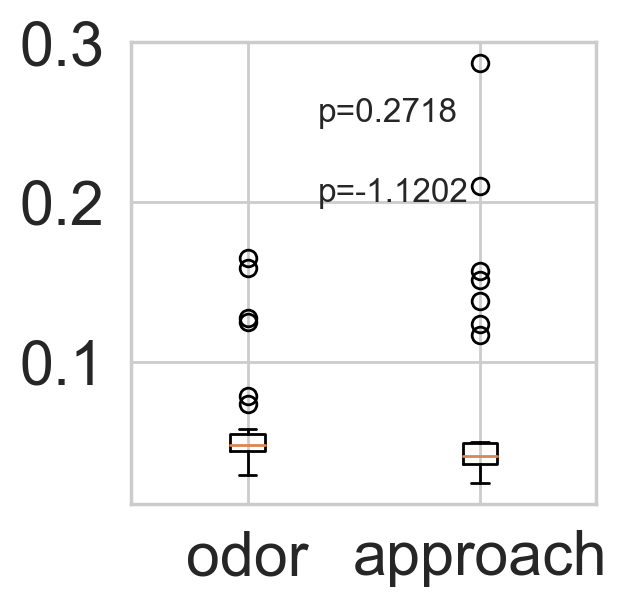

In [14]:
fig, ax = plt.subplots(figsize=(3,3))
    
ax.boxplot([means_odorsamp, means_approach])
ax.set_xticklabels(['odor','approach'])

tstat,pval = stats.ttest_rel(means_odorsamp,means_approach,alternative='two-sided')
ax.text(s='p='+str(round(pval,4)),x=1.3,y=0.25,fontsize=12)
ax.text(s='p='+str(round(tstat,4)),x=1.3,y=0.2,fontsize=12)

## compare _median_ low gamma amplitudes across wires
Just in case the mean is getting pulled wildly by outlier amplitudes within some sessions (e.g. noisier sessions).

In [15]:
medians_odorsamp = []
medians_approach = []
for wire in range(nwires): 
    
    medians_odorsamp.append(np.median(amps_odorsamp[wire]))
    medians_approach.append(np.median(amps_approach[wire]))

Text(1.3, 0.1, 't=1.0909')

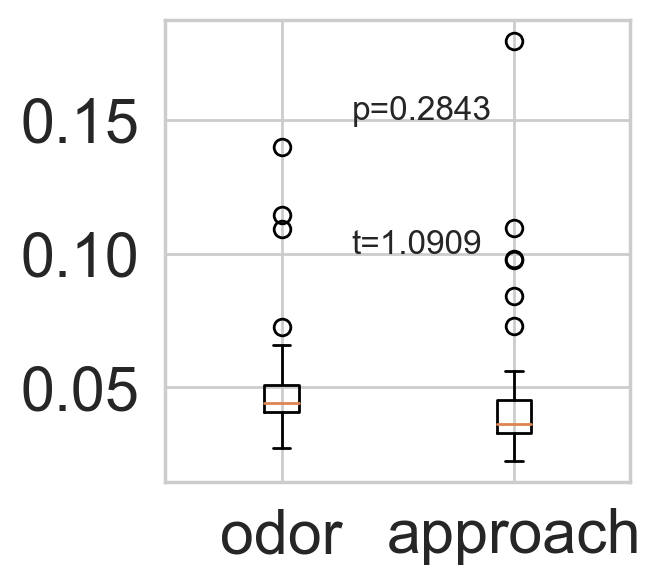

In [16]:
fig, ax = plt.subplots(figsize=(3,3))
    
ax.boxplot([medians_odorsamp, medians_approach])
ax.set_xticklabels(['odor','approach'])

tstat,pval = stats.ttest_rel(medians_odorsamp,medians_approach,alternative='two-sided')
ax.text(s='p='+str(round(pval,4)),x=1.3,y=0.15,fontsize=12)
ax.text(s='t='+str(round(tstat,4)),x=1.3,y=0.1,fontsize=12)